In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [2]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append("/home/Developer/NCSN-TF2.0/")

import PIL
import utils, configs
import argparse
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras import Model, layers
from tensorflow.keras.layers import Input, Flatten, Dense, AvgPool2D

from datasets.dataset_loader import  *
from tqdm import tqdm
from sklearn.metrics import classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

from PIL import Image
from IPython.display import display
from matplotlib.pyplot import imshow
from datetime import datetime

import seaborn as sns
sns.set(style="darkgrid")
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

tf.__version__

'2.2.0'

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [5]:
def get_command_line_args(_args):
    parser = utils._build_parser()

    parser = parser.parse_args(_args)

    utils.check_args_validity(parser)

    print("=" * 20 + "\nParameters: \n")
    for key in parser.__dict__:
        print(key + ': ' + str(parser.__dict__[key]))
    print("=" * 20 + "\n")
    return parser

In [6]:
def metrics(inlier_score, outlier_score, plot=False, verbose=False):
    from sklearn.metrics import roc_curve
    from sklearn.metrics import classification_report, average_precision_score
    from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
    
    y_true = np.concatenate((np.zeros(len(inlier_score)),
                             np.ones(len(outlier_score))))
    y_scores = np.concatenate((inlier_score, outlier_score))
    
    prec,rec,thresh = precision_recall_curve(y_true, y_scores)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    roc_auc = roc_auc_score(y_true,y_scores)
    pr_auc = auc(rec,prec)
    ap = average_precision_score(y_true,y_scores)
    
    if plot:    
    
        fig, axs = plt.subplots(1,2, figsize=(16,4))

        sns.lineplot(fpr, tpr, ax=axs[0])
        axs[0].set(
            xlabel="FPR", ylabel="TPR", title="ROC"
        )

        sns.lineplot(rec, prec, ax=axs[1])
        axs[1].set(
            xlabel="Recall", ylabel="Precision", title="Precision-Recall"
        )

        plt.show()
        plt.close()
    
    if verbose:
        print("Inlier vs Outlier")
        print("----------------")
        print("ROC-AUC: {:.4f}".format(roc_auc))
        print("PR-AUC: {:.4f}".format(pr_auc))
        print("Avg Prec: {:.4f}".format(ap))
        
    return roc_auc, ap, pr_auc

In [7]:
from scipy.ndimage import uniform_filter, median_filter

#Smooth first to get rid of spurious outliers
def preproc(x, orig=None):
    x = np.abs(uniform_filter(x, size=3))
    
    # Only consider foreground pixels
#     x = x[orig>0]
    return x

# Selecting Quantile for best separation
def getQuantiles(logits,orig, Q=0.95):    
    quants = [np.quantile(preproc(x,o), Q) for x,o in zip(logits, orig)]
    quants = np.array(quants).reshape(-1,1)
    return quants

## Generating Samples

In [8]:
args = get_command_line_args(["--model=refinenet",
                              "--checkpoint_dir=saved_models/",
                              "--filters=64",
                              "--dataset=seg_brain",
                              "--sigma_low=0.01",
                              "--sigma_high=1",
                              "--y_cond"
                             ])
configs.config_values = args
NUM_L = configs.config_values.num_L
SIGMA_HIGH = configs.config_values.sigma_high
SIGMA_LOW = configs.config_values.sigma_low
BEST_SIGMA_IDX = configs.config_values.num_L - 1
SIGMA_LEVELS = tf.math.exp(tf.linspace(tf.math.log(SIGMA_HIGH),
                                       tf.math.log(SIGMA_LOW),
                                       NUM_L))
SPLITS = utils.dict_splits[configs.config_values.dataset]
SPLITS

Parameters: 

experiment: train
dataset: seg_brain
model: refinenet
filters: 64
num_L: 10
sigma_low: 0.01
sigma_high: 1.0
sigma_sequence: geometric
steps: 200000
learning_rate: 0.001
batch_size: 128
samples_dir: ./samples/
checkpoint_dir: saved_models/
checkpoint_freq: 5000
resume: True
resume_from: -1
init_samples: 
k: 10
eval_setting: sample
ocnn: False
y_cond: True
max_to_keep: 2



(1, 7)

In [9]:
# save_dir, complete_model_name = utils.get_savemodel_dir()
# brain_model_cond, _, step, _,_ = utils.try_load_model(save_dir,
#                                               step_ckpt=configs.config_values.resume_from,
#                                               verbose=True)

In [10]:
args = get_command_line_args(["--model=refinenet",
                              "--checkpoint_dir=saved_models/",
                              "--filters=64",
                              "--dataset=brain",
                              "--sigma_low=0.01",
                              "--sigma_high=1",
                             ])
configs.config_values = args
save_dir, complete_model_name = utils.get_savemodel_dir()
brain_model, _, step, _,_ = utils.try_load_model(save_dir,
                                              step_ckpt=configs.config_values.resume_from,
                                              verbose=True)

Parameters: 

experiment: train
dataset: brain
model: refinenet
filters: 64
num_L: 10
sigma_low: 0.01
sigma_high: 1.0
sigma_sequence: geometric
steps: 200000
learning_rate: 0.001
batch_size: 128
samples_dir: ./samples/
checkpoint_dir: saved_models/
checkpoint_freq: 5000
resume: True
resume_from: -1
init_samples: 
k: 10
eval_setting: sample
ocnn: False
y_cond: False
max_to_keep: 2

(1, 91, 109, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 91, 109, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 91, 109, 64)  640         images[0][0]                     
__________________________________________________________________________________________

In [11]:
SPLITS

(1, 7)

In [12]:
def load_outlier_data(age="1year"):
    
    DATA_DIR = "/home/Developer/anodetect/data/test/"
    test_paths = glob.glob(DATA_DIR+"/"+age+"/*")
    
    # Create a dictionary describing the features.
    image_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
        'segmentation': tf.io.FixedLenFeature([], tf.string),
    }

    @tf.function
    def _parse_record(example_proto):
        # Parse the input tf.Example proto using the dictionary above.
        return tf.io.parse_single_example(example_proto, image_feature_description)

    @tf.function
    def _parse_mri(example_proto):
        
        # Get the record and put it into a feature dict
        image_features = _parse_record(example_proto)
        
        # Deserialize the mri array 
        mri = tf.io.parse_tensor(image_features['image'],
                                out_type=tf.float32)
        mask = tf.io.parse_tensor(image_features['mask'],
                                out_type=tf.float32)
        seg = tf.io.parse_tensor(image_features['segmentation'],
                                out_type=tf.float32)
        
        mri  = tf.expand_dims(mri, axis=-1)
        seg = tf.cast(tf.squeeze(seg), dtype=tf.int32)
        seg = tf.one_hot(seg, depth=7)
#         x = tf.concat((mri,mask,seg), axis=-1)
        x = tf.concat((mri,seg), axis=-1)
        
        return x

    test  = tf.data.TFRecordDataset(test_paths).map(_parse_mri)

    return test, len(test_paths)

In [13]:
# import tensorflow.keras as keras

# def build(model):
#     x = [layers.Input(name="images", shape=model.in_shape[0][1:]),
#                  layers.Input(name="idx_sigmas", shape=(), dtype=tf.int32)]
#     return keras.Model(inputs=x, outputs=model.call(x))

# m= build(brain_model)
# m.summary()

In [14]:
brain_model

In [15]:
SIGMAS = utils.get_sigma_levels().numpy()

> ### Note that since we do not have masks, background values are not exactly zero
> ### Use an eps instead (default: 1e-10)

In [16]:
@tf.function
def perturb(x):
    x_batch, y_cond = tf.split(x, SPLITS, axis=-1)
    perturbation =  tf.random.normal(shape=x_batch.shape, mean=0, stddev=SIGMA_VALUE)
    x_perturbed = x_batch + perturbation
    x = tf.concat((x_perturbed, y_cond), axis=-1)
    return x

@tf.function
def score_batch(x_batch):
#     x_batch = perturb(x_batch)
    score = brain_model([x_batch, idx_sigmas])
    return score

In [17]:
@tf.function
def remove_segs(x):
    x, segs = tf.split(x, SPLITS, axis=-1)
    return x

In [18]:
# Test Samples in ABCD
min_size = 900
x_outliers = []
ages = ["1year", "2year"]
for age in ages[0:]:
    x_outlier, test_size = load_outlier_data(age)
    x_outliers.append(x_outlier)
    if min_size > test_size:
        min_size = test_size

print("Choosing Sample Size:", min_size)

Choosing Sample Size: 582


In [19]:
TEST_BATCH=min_size//10

In [20]:
BATCH_COUNT = test_size // TEST_BATCH
print("Testing {} batches of {}: {} samples".format(BATCH_COUNT, TEST_BATCH, TEST_BATCH*BATCH_COUNT))

outlier_datasets = []
for x_outlier in x_outliers:
    x_outlier = x_outlier.shuffle(1000)
    x_outlier = x_outlier.map(remove_segs)
    x_outlier = x_outlier.batch(TEST_BATCH).take(BATCH_COUNT).prefetch(tf.data.experimental.AUTOTUNE).cache()
#     outlier_batch = next(iter(x_outlier))
    outlier_datasets.append(x_outlier)


Testing 10 batches of 58: 580 samples


### Getting train/test inlier distributions

In [21]:
!ls /home/Developer/anodetect/data/processed/images/test | wc -l

1137


In [22]:
x_test_ =  get_train_test_data("seg_brain")[1]
x_test_ = x_test_.map(remove_segs).batch(200)

# x_train = x_test_.take(1000)
# x_train = x_train.batch(256).prefetch(tf.data.experimental.AUTOTUNE)

# x_test = x_test_.skip(1000)
# x_test = x_test.batch(137).prefetch(tf.data.experimental.AUTOTUNE)

inlier_batches = [x for x in x_test_]
len(inlier_batches), [x.shape[0] for x in inlier_batches]

(6, [200, 200, 200, 200, 200, 137])

In [71]:
x_train, x_test = inlier_batches[:-2], inlier_batches[-2:]
x_test[0].shape

TensorShape([200, 91, 109, 1])

## Mixing Scores

In [24]:
def compute_scores(x_test):
    
    # Sigma Idx -> Score
    score_dict = []
    
    sigmas = utils.get_sigma_levels().numpy()
    final_logits = 0 #tf.zeros(logits_shape)
    progress_bar = tqdm(SIGMAS, desc='Sigma: ?')
    for idx, sigma in enumerate(progress_bar):
        
        progress_bar.set_description("Sigma: {:.4f}".format(sigma))
        _logits =[]

        for x_batch in x_test:
            idx_sigmas = tf.ones(x_batch.shape[0], dtype=tf.int32) * idx
            score = brain_model([x_batch, idx_sigmas])
#             x_batch, y_cond = tf.split(x_batch, SPLITS, axis=-1)
#             score = tf.where(x_batch > 1e-10, score,  0)
            _logits.append(score)

        _logits = tf.concat(_logits, axis=0)
        score_dict.append(tf.identity(_logits))
        
#         final_logits += _logits * sigma
    
    return score_dict

In [72]:
%%time
inlier_train_dist = compute_scores(x_train)

Sigma: 0.0100: 100%|██████████| 10/10 [01:04<00:00,  6.43s/it]

CPU times: user 19.6 s, sys: 15.5 s, total: 35.1 s
Wall time: 1min 4s


In [73]:
%%time
inlier_dist = compute_scores(x_test)

outlier_dist = compute_scores(outlier_datasets[0])

outlier_dist_2 = compute_scores(outlier_datasets[1])

Sigma: 0.0100: 100%|██████████| 10/10 [00:47<00:00,  4.74s/it]

CPU times: user 53 s, sys: 16.1 s, total: 1min 9s
Wall time: 2min 3s


In [74]:
# L2-norm same as Frobenius
train_agg = tf.add_n([inlier_train_dist[x] * s for x, s in enumerate(SIGMAS)])
inlier_agg = tf.add_n([inlier_dist[x] * s for x, s in enumerate(SIGMAS)])
outlier_agg = tf.add_n([outlier_dist[x] * s for x,s in enumerate(SIGMAS)])
outlier_agg_2 = tf.add_n([outlier_dist_2[x] * s for x,s in enumerate(SIGMAS)])

train_score = tf.norm(train_agg, axis=[1,2], ord="euclidean").numpy()
inlier_score = tf.norm(inlier_agg, axis=[1,2], ord="euclidean").numpy()
outlier_score = tf.norm(outlier_agg, axis=[1,2], ord="euclidean").numpy()
outlier_score_2 = tf.norm(outlier_agg_2, axis=[1,2], ord="euclidean").numpy()

In [75]:
# inlier_score = tf.norm(inlier_logits, axis=[1,2], ord="euclidean").numpy()
# outlier_score = tf.norm(outlier_logits, axis=[1,2], ord="euclidean").numpy()


df = pd.DataFrame(np.concatenate((train_score[:len(inlier_score)],
                                  inlier_score, 
                                  outlier_score[:len(inlier_score)],
                                  outlier_score_2[:len(inlier_score)]), axis=-1),
             columns=["Train", "Test", "1 year", "2 year"])
df.describe()

,Train,Test,1 year,2 year
count,337.000000,337.000000,337.000000,337.000000
mean,353.830017,354.139587,372.645508,365.719543
std,12.753666,11.292300,14.762607,13.877604
min,321.202728,327.018066,326.213196,327.297577
25%,344.756470,346.642303,363.066193,356.639282
50%,353.921539,353.088837,372.786438,366.930725
75%,361.872833,360.531311,382.231476,375.736786
max,404.612152,384.553894,411.014038,402.158203


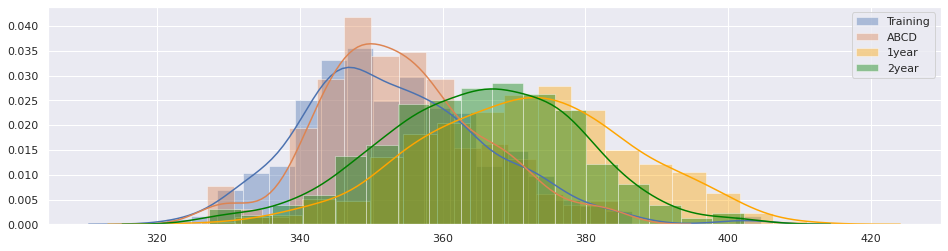

In [76]:
fig, ax = plt.subplots(1,1, figsize=(16,4))
labels = ["ABCD"]+ages
sns.distplot(train_score, label="Training", ax=ax)
sns.distplot(inlier_score, label=labels[0], ax=ax)
sns.distplot(outlier_score, color="orange", label=labels[1], ax=ax)
sns.distplot(outlier_score_2, color="green", label=labels[2], ax=ax)
plt.legend()
plt.show()

**ABCD vs 1-year**

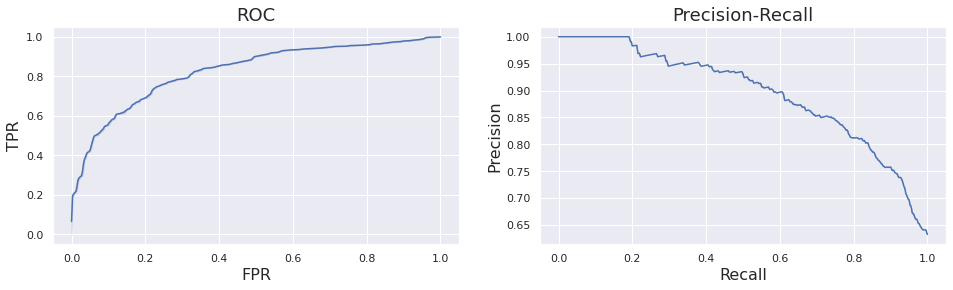

Inlier vs Outlier
----------------
ROC-AUC: 0.8264
PR-AUC: 0.8956
Avg Prec: 0.8957


In [77]:
metrics(inlier_score, outlier_score, plot=True, verbose=True)
plt.show()

**ABCD vs 2-year**

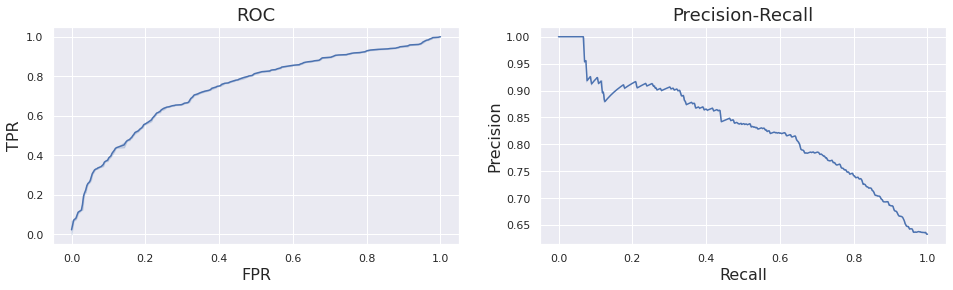

Inlier vs Outlier
----------------
ROC-AUC: 0.7373
PR-AUC: 0.8285
Avg Prec: 0.8287


In [78]:
metrics(inlier_score, outlier_score_2, plot=True, verbose=True)
plt.show()

## Train Data = L2-norm(Pixel Scores)

In [79]:
%%time
train_data, test_data = [], []
outlier_data_1, outlier_data_2 = [], [] 

for x, s in enumerate(SIGMAS):
    train_data.append(tf.norm(inlier_train_dist[x] * s, axis=[1,2], ord="euclidean").numpy())
    test_data.append(tf.norm(inlier_dist[x] * s, axis=[1,2], ord="euclidean").numpy())
    outlier_data_1.append(tf.norm(outlier_dist[x] * s, axis=[1,2], ord="euclidean").numpy())
    outlier_data_2.append(tf.norm(outlier_dist_2[x] * s, axis=[1,2], ord="euclidean").numpy())
    
train_data = np.concatenate(train_data, axis=1)
test_data = np.concatenate(test_data, axis=1)
outlier_data_1 = np.concatenate(outlier_data_1, axis=1)
outlier_data_2 = np.concatenate(outlier_data_2, axis=1)

CPU times: user 58.2 ms, sys: 86 ms, total: 144 ms
Wall time: 202 ms


In [80]:
X_train, X_test = train_data, test_data

### OC-SVM

In [81]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from helper import plot_confusion_matrix

In [82]:
%%time
clf = svm.OneClassSVM(nu=0.01, kernel="rbf")
clf.fit(train_data)

CPU times: user 3.12 ms, sys: 2.05 ms, total: 5.17 ms
Wall time: 3.79 ms


OneClassSVM(nu=0.01)

In [83]:
y_true = np.concatenate((np.zeros(len(test_data)),
                         np.ones(len(outlier_data_1))))

# Rescaling: 0 = inlier , 1 = outlier
test_pred = (1-clf.predict(test_data)) // (2)
outlier_pred = (1-clf.predict(outlier_data_1)) // 2
y_pred = np.concatenate((test_pred, outlier_pred))

print(classification_report(y_true, y_pred, target_names=["Inlier","1-Year"]))

              precision    recall  f1-score   support

      Inlier       0.69      1.00      0.81       337
      1-Year       1.00      0.74      0.85       580

    accuracy                           0.83       917
   macro avg       0.84      0.87      0.83       917
weighted avg       0.89      0.83      0.84       917



> **Low precision => Low PPV => High False Positives**

In [84]:
y_true = np.concatenate((np.zeros(len(test_data)),
                         np.ones(len(outlier_data_2))))

# Rescaling: 0 = inlier , 1 = outlier
outlier_pred = (1-clf.predict(outlier_data_2)) // 2
y_pred = np.concatenate((test_pred, outlier_pred))

print(classification_report(y_true, y_pred, target_names=["Inlier","4-Year"]))

              precision    recall  f1-score   support

      Inlier       0.53      1.00      0.70       337
      4-Year       1.00      0.49      0.66       580

    accuracy                           0.68       917
   macro avg       0.77      0.75      0.68       917
weighted avg       0.83      0.68      0.67       917



### Grid Search
> **Defaults w/ rbf seem to work best**

In [85]:
y_train = np.ones(len(train_data))

params = {"nu":[0.01, 0.02, 0.001],
          "gamma": ["scale", "auto"],
          "shrinking": [True, False],
          "kernel": ["rbf", "poly", "sigmoid"]
         }

grid = GridSearchCV(estimator=svm.OneClassSVM(), param_grid=params, n_jobs=12,
                    cv=10, scoring="precision", verbose=1)
print(grid)

GridSearchCV(cv=10, estimator=OneClassSVM(), n_jobs=12,
             param_grid={'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'poly', 'sigmoid'],
                         'nu': [0.01, 0.02, 0.001],
                         'shrinking': [True, False]},
             scoring='precision', verbose=1)


In [86]:
%%time
grid.fit(train_data, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  27 tasks      | elapsed:    1.2s


CPU times: user 535 ms, sys: 1.12 s, total: 1.66 s
Wall time: 1.83 s


[Parallel(n_jobs=12)]: Done 337 out of 360 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=12)]: Done 360 out of 360 | elapsed:    1.8s finished


GridSearchCV(cv=10, estimator=OneClassSVM(), n_jobs=12,
             param_grid={'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'poly', 'sigmoid'],
                         'nu': [0.01, 0.02, 0.001],
                         'shrinking': [True, False]},
             scoring='precision', verbose=1)

In [87]:
grid.best_params_

{'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.01, 'shrinking': True}

In [88]:
%%time

clf = svm.OneClassSVM(**grid.best_params_)
clf.fit(train_data)

y_true = np.concatenate((np.zeros(len(test_data)),
                         np.ones(len(outlier_data_1))))

# Rescaling: 0 = inlier , 1 = outlier
test_pred = (1-clf.predict(test_data)) // (2)
outlier_pred = (1-clf.predict(outlier_data_1)) // 2
y_pred = np.concatenate((test_pred, outlier_pred))

print(classification_report(y_true, y_pred, target_names=["Inlier","1-Year"]))

              precision    recall  f1-score   support

      Inlier       0.69      1.00      0.81       337
      1-Year       1.00      0.74      0.85       580

    accuracy                           0.83       917
   macro avg       0.84      0.87      0.83       917
weighted avg       0.89      0.83      0.84       917

CPU times: user 12.3 ms, sys: 1.8 ms, total: 14.1 ms
Wall time: 11.8 ms


Confusion matrix, without normalization
[[1.        0.       ]
 [0.2637931 0.7362069]]
Overall Accuracy: 0.8332


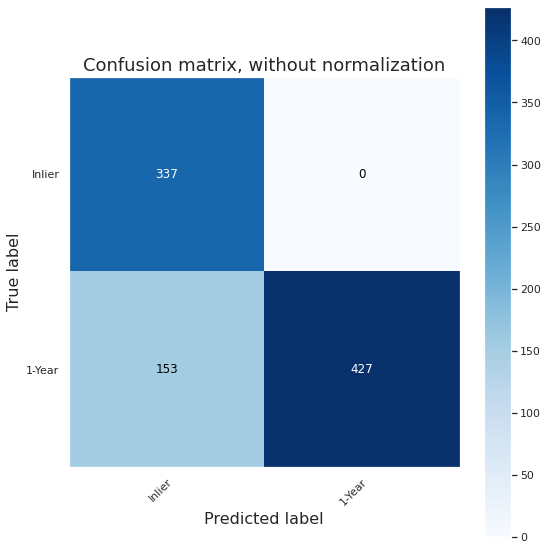

In [89]:
plot_confusion_matrix(y_true, y_pred, classes=["Inlier","1-Year"])
plt.grid(False)

## GMM

In [90]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [91]:
%%time
gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
])

param_grid = dict(GMM__n_components = range(1,11),
                  GMM__covariance_type = ['spherical', 'diag', "full", "tied"])

grid = GridSearchCV(estimator=gmm_clf,
                    param_grid=param_grid,
                    cv=10, n_jobs=10,
                    verbose=1)

grid_result = grid.fit(train_data)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.5s


CPU times: user 950 ms, sys: 53.3 ms, total: 1 s
Wall time: 2.61 s


[Parallel(n_jobs=10)]: Done 400 out of 400 | elapsed:    2.5s finished


In [92]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("-----"*15)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best: 1.417268 using {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
---------------------------------------------------------------------------


In [243]:
### Using BIC - Likelihoods NOT as good as CV

# bic_gmm = None
# lowest_bic = np.infty
# bics = {}
# n_components_range = range(1, 11)
# cv_types = ['spherical', 'tied', 'diag', 'full']
# scaler = StandardScaler()
# _x_train = scaler.fit_transform(X_train)

# for cv_type in cv_types:
#     for n_components in n_components_range:
#         # Fit a Gaussian mixture with EM
#         gmm = GaussianMixture(n_components=n_components, covariance_type=cv_type)
#         gmm.fit(_x_train)
#         bic = gmm.bic(_x_train)
        
#         if n_components in bics:
#             bics[n_components].append(bic)
#         else:
#             bics[n_components] = [bic]
        
#         if bic < lowest_bic:
#             lowest_bic = bic
#             bic_gmm = gmm
# bic_gmm

# bics = pd.DataFrame(bics, index=['spherical', 'tied', 'diag', 'full']).T
# bics.plot(kind="bar", figsize=(20,4))

# print("Training Likelihood: {:.3f}".format(bic_gmm.score(X_train)))
# print("Testing Likelihood: {:.3f}".format(bic_gmm.score(X_test)))
# print("1-year Likelihood: {:.3f}".format(bic_gmm.score(outlier_data_1)))
# print("2-year Likelihood: {:.3f}".format(bic_gmm.score(outlier_data_2)))

In [93]:
best_params = grid.best_params_

best_gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
]).set_params(**best_params)

best_gmm_clf.fit(X_train)

print("Training Likelihood: {:.3f}".format(best_gmm_clf.score(X_train)))
print("Testing Likelihood: {:.3f}".format(best_gmm_clf.score(X_test)))
print("1-year Likelihood: {:.3f}".format(best_gmm_clf.score(outlier_data_1)))
print("2-year Likelihood: {:.3f}".format(best_gmm_clf.score(outlier_data_2)))

Training Likelihood: 1.976
Testing Likelihood: 1.870
1-year Likelihood: -41.278
2-year Likelihood: -35.715


In [45]:
best_params = grid.best_params_

best_gmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("GMM", GaussianMixture())
]).set_params(**best_params)

best_gmm_clf.fit(X_train)

print("Training Likelihood: {:.3f}".format(best_gmm_clf.score(X_train)))
print("Testing Likelihood: {:.3f}".format(best_gmm_clf.score(X_test)))
print("1-year Likelihood: {:.3f}".format(best_gmm_clf.score(outlier_data_1)))
print("2-year Likelihood: {:.3f}".format(best_gmm_clf.score(outlier_data_2)))

Training Likelihood: 1.768
Testing Likelihood: 1.929
1-year Likelihood: -42.786
2-year Likelihood: -36.653


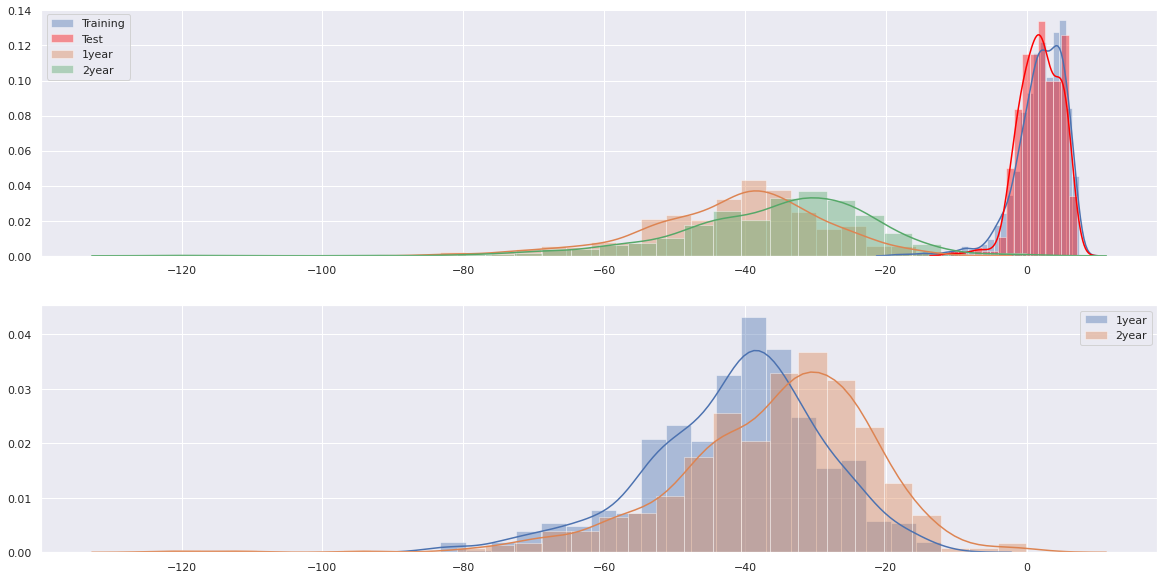

In [97]:
train_score = best_gmm_clf.score_samples(X_train)
test_score = best_gmm_clf.score_samples(X_test)
outlier_score = best_gmm_clf.score_samples(outlier_data_1)
outlier_score_2 = best_gmm_clf.score_samples(outlier_data_2)

fig, axs = plt.subplots(2,1, figsize=(20,10))
labels = ["Test"]+ages

sns.distplot(train_score, label="Training", ax=axs[0])

sns.distplot(test_score, color="red", label=labels[0], ax=axs[0])
sns.distplot(outlier_score, label=labels[1], ax=axs[0])
sns.distplot(outlier_score_2, label=labels[2], ax=axs[0])

# sns.distplot(train_score, label="Training", ax=axs[1])
sns.distplot(outlier_score, label=labels[1], ax=axs[1])
sns.distplot(outlier_score_2, label=labels[2], ax=axs[1])

axs[0].legend()
axs[1].legend()
plt.show()

**ABCD vs 1-year**

In [98]:
metrics(-test_score, -outlier_score, plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 1.0000
PR-AUC: 1.0000
Avg Prec: 1.0000


**ABCD vs 2-year**

In [99]:
metrics(-test_score, -outlier_score_2, plot=False, verbose=True)
plt.show()

Inlier vs Outlier
----------------
ROC-AUC: 0.9992
PR-AUC: 0.9996
Avg Prec: 0.9996


## Bayesian GMM

In [63]:
from sklearn.mixture import BayesianGaussianMixture

In [64]:
%%time
bgmm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("BGMM", BayesianGaussianMixture())
])

param_grid = dict(BGMM__n_components = [10],
                  BGMM__covariance_type = ["full","tied", 'spherical', 'diag'],
                  BGMM__max_iter=[200],
                  BGMM__init_params= ["kmeans", "random"],
                  BGMM__n_init=[5],
                  BGMM__weight_concentration_prior_type=["dirichlet_process", "dirichlet_distribution"]
                 )

grid = GridSearchCV(estimator=bgmm_clf,
                    param_grid=param_grid,
                    cv=10, n_jobs=12, verbose=1)

grid_result = grid.fit(X_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   11.6s
[Parallel(n_jobs=12)]: Done 160 out of 160 | elapsed:   31.8s finished


CPU times: user 14.1 s, sys: 17.9 s, total: 31.9 s
Wall time: 34.7 s


In [65]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.865288 using {'BGMM__covariance_type': 'tied', 'BGMM__init_params': 'kmeans', 'BGMM__max_iter': 200, 'BGMM__n_components': 10, 'BGMM__n_init': 5, 'BGMM__weight_concentration_prior_type': 'dirichlet_distribution'}


In [66]:
best_params = grid.best_params_
best_bgmm_clf = bgmm_clf.set_params(**best_params)
best_bgmm_clf.fit(X_train)


print("Training Likelihood: {:.3f}".format(best_bgmm_clf.score(X_train)))
print("Testing Likelihood: {:.3f}".format(best_bgmm_clf.score(X_test)))
print("1-year Likelihood: {:.3f}".format(best_bgmm_clf.score(outlier_data_1)))
print("2-year Likelihood: {:.3f}".format(best_bgmm_clf.score(outlier_data_2)))

Training Likelihood: 1.585
Testing Likelihood: 1.622
1-year Likelihood: -46.788
2-year Likelihood: -36.859


In [188]:
best_params = grid.best_params_
best_bgmm_clf = bgmm_clf.set_params(**best_params)
best_bgmm_clf.fit(X_train)


print("Training Likelihood: {:.3f}".format(best_bgmm_clf.score(X_train)))
print("Testing Likelihood: {:.3f}".format(best_bgmm_clf.score(X_test)))
print("1-year Likelihood: {:.3f}".format(best_bgmm_clf.score(outlier_data_1)))
print("2-year Likelihood: {:.3f}".format(best_bgmm_clf.score(outlier_data_2)))

Training Likelihood: 1.703
Testing Likelihood: 1.861
1-year Likelihood: -43.848
2-year Likelihood: -37.701


In [69]:
train_data.shape

(1000, 10)

0: -1.395858 using {'GMM__covariance_type': 'diag', 'GMM__n_components': 3}
1: -1.407347 using {'GMM__covariance_type': 'full', 'GMM__n_components': 3}
2: -1.405388 using {'GMM__covariance_type': 'spherical', 'GMM__n_components': 4}
3: -1.425738 using {'GMM__covariance_type': 'tied', 'GMM__n_components': 5}
4: -1.425041 using {'GMM__covariance_type': 'diag', 'GMM__n_components': 2}
5: -1.425599 using {'GMM__covariance_type': 'tied', 'GMM__n_components': 1}
6: -1.410897 using {'GMM__covariance_type': 'full', 'GMM__n_components': 3}
7: -1.413711 using {'GMM__covariance_type': 'full', 'GMM__n_components': 3}
8: -1.419358 using {'GMM__covariance_type': 'spherical', 'GMM__n_components': 8}
9: -1.415577 using {'GMM__covariance_type': 'tied', 'GMM__n_components': 3}


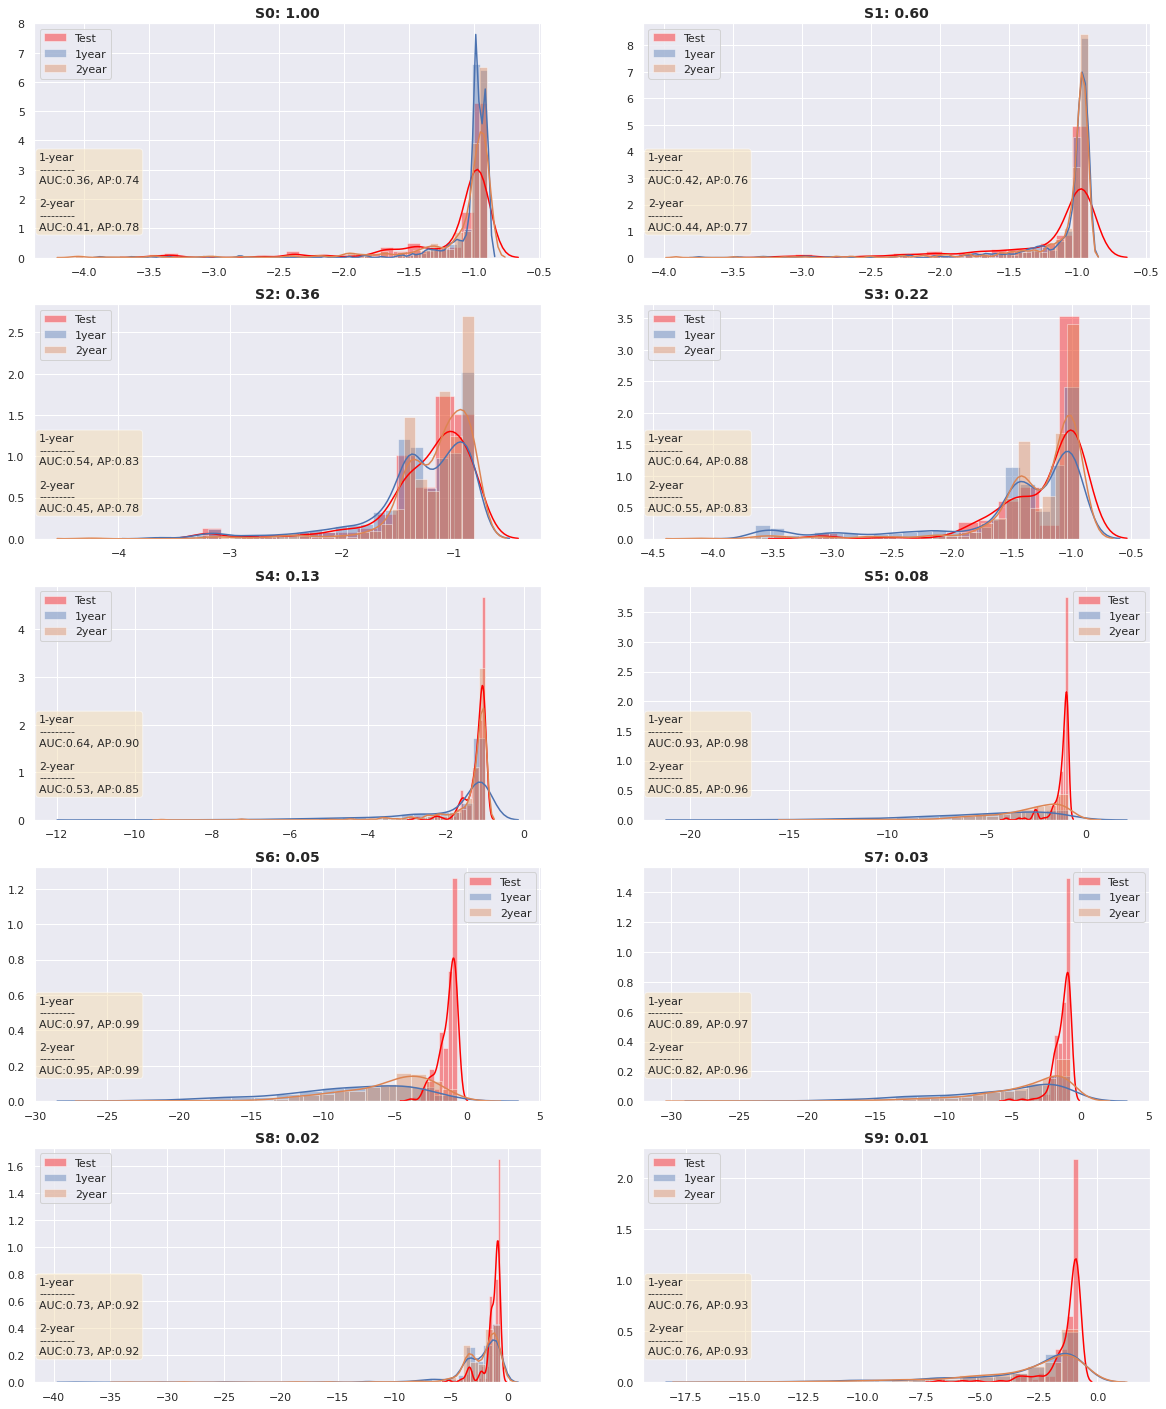

In [70]:
# progress_bar = tqdm(sigmas, desc='Sigma: ?')
fig, axs = plt.subplots(5,2, figsize=(20,25))
axs = axs.flatten()

for idx, sigma in enumerate(SIGMAS):
    _x_train = train_data[:, idx:idx+1]
    _x_test = test_data[:, idx:idx+1]
    _yr1 = outlier_data_1[:, idx:idx+1]
    _yr2 = outlier_data_2[:, idx:idx+1]
    
    gmm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("GMM", GaussianMixture())
    ])
    
    
    # Each sigma gets its own hyperparameter-tuned model
    param_grid = dict(GMM__n_components = range(1,11),
                      GMM__covariance_type = ['spherical', 'diag', "full", "tied"])

    grid = GridSearchCV(estimator=gmm_clf,
                        param_grid=param_grid,
                        cv=10, n_jobs=12)
    grid_result = grid.fit(_x_train)
    print("%d: %f using %s" % (idx, grid_result.best_score_, grid_result.best_params_))
    
    
    best_gmm_clf = gmm_clf.set_params(**grid.best_params_)
    best_gmm_clf.fit(_x_train)
    
    _train_score = best_gmm_clf.score_samples(_x_train)
    _inlier_score = best_gmm_clf.score_samples(_x_test)
    yr1_score = best_gmm_clf.score_samples(_yr1)
    yr2_score = best_gmm_clf.score_samples(_yr2)

#     sns.distplot(_train_score, label="Training", ax=axs[idx])
    sns.distplot(_inlier_score, color="red", label=labels[0], ax=axs[idx])
    sns.distplot(yr1_score, label=labels[1], ax=axs[idx])
    sns.distplot(yr2_score, label=labels[2], ax=axs[idx])

    textstr = '\n'.join((
        '1-year',
        "---------",
        'AUC:%.2f, AP:%.2f' % (metrics(-_inlier_score, -yr1_score)[:-1]),
        '',
        '2-year',
        "---------",
        'AUC:%.2f, AP:%.2f' % (metrics(-_inlier_score, -yr2_score)[:-1])))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    axs[idx].text(0.01, 0.45, textstr, transform=axs[idx].transAxes, fontsize=11,
            verticalalignment='top', bbox=props)
    
    axs[idx].set_title("S{:d}: {:.2f}".format(idx, sigma), fontsize=14, fontweight="bold")  
    
    axs[idx].legend()

plt.show()

> **S6 shows the best separation**